In [1]:
%load_ext autoreload
%autoreload 2

# standard python imports
import numpy as np
import matplotlib.pyplot as plt

# tidy3d imports
import tidy3d as td
import tidy3d.web as web

Using Tidy3D credentials from stored file


In [2]:
# 1 nanometer in units of microns (for conversion)
nm = 1e-3

# free space central wavelength
wavelength = 1

# thickness of ring and spacing
S = wavelength / 4

# height / thickness of ring
H = 400 * nm

# space between bottom PML and substrate (-z)
space_below_sub = 1 * wavelength

# thickness of substrate
thickness_sub = wavelength / 3

# side length of entire metalens (um)
side_length = 15 * wavelength

# projection length
# z0 = 15 * wavelength
z0 = 36 * wavelength

# Number of unit cells in each x and y direction (NxN grid)
N = int(side_length / 2 / S / 2)
print(f'for diameter of {side_length:.1f} um, have {N / 2} rings')

# Define material properties at 600 nm
n_TiO2 = 2.40
n_SiO2 = 1.46
air = td.Medium(permittivity=1.0)
SiO2 = td.Medium(permittivity=n_SiO2**2)

# resolution control
grids_per_wavelength = 25

# Number of PML layers to use along z direction
npml = grids_per_wavelength

for diameter of 15.0 um, have 7.5 rings


## Process Geometry

Next we need to do conversions to get the problem parameters ready to define the simulation.

In [3]:
# grid size (um)
dl = wavelength / grids_per_wavelength

# using the wavelength in microns, one can use td.C_0 (um/s) to get frequency in Hz
# wavelength_meters = wavelength * meters
f0 = td.C_0 / wavelength

# Define PML layers, for this we have no PML in x, y but `npml` cells in z
pml_layers = [npml, npml, npml]
pml_thickness = npml * dl
pml_layers = 3*[td.PML()]

# Compute the domain size in x, y (note: round down from side_length)
# length_xy = N * S * 7
# length_xy = 15 * wavelength * 7 / 4
length_xy = N * S * 7 - 5 * wavelength

# total domain size in z: (PML -> space -> substrate -> unit cell -> 1.7 focal lengths -> PML)
length_z = space_below_sub + thickness_sub + H + z0 + 5 * space_below_sub

# construct simulation size array
sim_size = (length_xy, length_xy, length_z)

In [4]:
# define substrate
substrate = td.Structure(
    geometry=td.Box(
        center=[0, 0, -length_z/2 + space_below_sub + thickness_sub / 2.0],
        size=[length_xy, length_xy, thickness_sub]
    ),
    medium=SiO2
)

# create a running list of structures
geometry = [substrate]

width = 1 * wavelength

pec_center_z = -length_z/2 + space_below_sub + thickness_sub + H / 2

left = td.Structure(
    geometry=td.Box(
        center=[-length_xy/4-width-wavelength/2, 0, pec_center_z],
        size=[length_xy/2+width/4+wavelength, td.inf, thickness_sub]),
    medium=td.PEC)
right = td.Structure(
    geometry=td.Box(
        center=[+length_xy/4+width+wavelength/2, 0, pec_center_z],
        size=[length_xy/2+width/4+wavelength, td.inf, thickness_sub]),
    medium=td.PEC)
top = td.Structure(
    geometry=td.Box(
        center=[0, -length_xy/4-width-wavelength/2, pec_center_z],
        size=[td.inf, length_xy/2+width/4+wavelength, thickness_sub]),
    medium=td.PEC)
bottom = td.Structure(
    geometry=td.Box(
        center=[0, +length_xy/4+width+wavelength/2, pec_center_z],
        size=[td.inf, length_xy/2+width/4+wavelength, thickness_sub]),
    medium=td.PEC)

geometry = [substrate, left, right, top, bottom]

In [5]:
# Bandwidth in Hz
fwidth = f0 / 10.0

# Gaussian source offset; the source peak is at time t = offset/fwidth
offset = 4.

# time dependence of source
gaussian = td.GaussianPulse(freq0=f0, fwidth=fwidth, offset=offset)

source = td.PlaneWave(
            center=(0,0,-length_z/2 + space_below_sub / 2),
            size=(td.inf, td.inf, 0),
            source_time=gaussian,
            direction='+',
            pol_angle=0)
            #polarization='Ex')

# Simulation run time past the source decay (around t=2*offset/fwidth)
run_time = 40 / fwidth

In [6]:
near_plane_z = -length_z/2 + space_below_sub + thickness_sub + H + 2 * space_below_sub
# near_plane_z = -length_z/2 + space_below_sub + thickness_sub + H + 0.5 * space_below_sub
# near_plane_z = pec_center_z# + thickness_sub/2
monitor_near = td.FieldMonitor(
                   center=[0., 0., near_plane_z],
                   size=[length_xy, length_xy, 0],
                   freqs=[f0],
                   name='near_field')

far_plane_xy = length_xy
far_plane_z = -length_z/2 + space_below_sub + thickness_sub + H + 2 * space_below_sub + z0
#far_plane_z = 10.0
monitor_far = td.FieldMonitor(
                   center=[0., 0., far_plane_z],
                   size=[far_plane_xy, far_plane_xy, 0],
                   freqs=[f0],
                   name='far_field')

monitors = [monitor_near, monitor_far]

mon_offsets = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
for offset in mon_offsets:
    monitor_far_offset = td.FieldMonitor(
                   center=[0., 0., far_plane_z - offset * wavelength],
                   size=[far_plane_xy, far_plane_xy, 0],
                   freqs=[f0],
                   name=f'far_field_{offset}')
    monitors.append(monitor_far_offset)


## Create Simulation

Now we can put everything together and define a simulation class to be run



In [7]:
sim = td.Simulation(
    size=sim_size,
    grid_size=[dl, dl, dl],
    structures=geometry,
    sources=[source],
    # monitors=[monitor_near, monitor_far],
    monitors=monitors,
    run_time=run_time,
    pml_layers=pml_layers
)

[13:10:55] WARNING  structure                                               ]8;id=695233;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=525463;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/components/simulation.py#243\243]8;;\
                                                                                             
                    geometry=Box(center=(0.0, 0.0, -20.2), type='Box',                       
                    size=(21.25, 21.25, 0.3333333333333333))                                 
                    medium=Medium(name=None, frequency_range=None,                           
                    type='Medium', permittivity=2.1315999999999997,                          
                    conductivity=0.0) name=None type='Structure'                             
                                                                                             
                    bounds extend exactly to simulation edges. This can                      
                    cause unexpected behavior. If intending to extend the                    
                    structure to infinity along one dimension, use td.inf                    
                    as a size variable instead to make this explicit.                        

           WARNING  structure                                               ]8;id=160838;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=490426;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/components/simulation.py#243\243]8;;\
                                                                                             
                    geometry=Box(center=(0.0, 0.0, -20.2), type='Box',                       
                    size=(21.25, 21.25, 0.3333333333333333))                                 
                    medium=Medium(name=None, frequency_range=None,                           
                    type='Medium', permittivity=2.1315999999999997,                          
                    conductivity=0.0) name=None type='Structure'                             
                                                                                             
                    bounds extend exactly to simulation edges. This can                      
                    cause unexpected behavior. If intending to extend the                    
                    structure to infinity along one dimension, use td.inf                    
                    as a size variable instead to make this explicit.                        

           WARNING  structure                                               ]8;id=135192;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=500794;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/components/simulation.py#243\243]8;;\
                                                                                             
                    geometry=Box(center=(0.0, 0.0, -20.2), type='Box',                       
                    size=(21.25, 21.25, 0.3333333333333333))                                 
                    medium=Medium(name=None, frequency_range=None,                           
                    type='Medium', permittivity=2.1315999999999997,                          
                    conductivity=0.0) name=None type='Structure'                             
                                                                                             
                    bounds extend exactly to simulation edges. This can                      
                    cause unexpected behavior. If intending to extend the                    
                    structure to infinity along one dimension, use td.inf                    
                    as a size variable instead to make this explicit.                        

           WARNING  structure                                               ]8;id=185591;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=206924;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/components/simulation.py#243\243]8;;\
                                                                                             
                    geometry=Box(center=(0.0, 0.0, -20.2), type='Box',                       
                    size=(21.25, 21.25, 0.3333333333333333))                                 
                    medium=Medium(name=None, frequency_range=None,                           
                    type='Medium', permittivity=2.1315999999999997,                          
                    conductivity=0.0) name=None type='Structure'                             
                                                                                             
                    bounds extend exactly to simulation edges. This can                      
                    cause unexpected behavior. If intending to extend the                    
                    structure to infinity along one dimension, use td.inf                    
                    as a size variable instead to make this explicit.                        

/Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/components/simulation.py:348: RuntimeWarning: divide by zero encountered in double_scalars
  lambda_min = C_0 / f_average / n_material


## Visualize Geometry

Lets take a look and make sure everything is defined properly


/Users/shashwat/Documents/flexcompute/repos/venvs/tidy3d-env/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/Users/shashwat/Documents/flexcompute/repos/venvs/tidy3d-env/lib/python3.9/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])


<Figure size 1440x576 with 6 Axes>

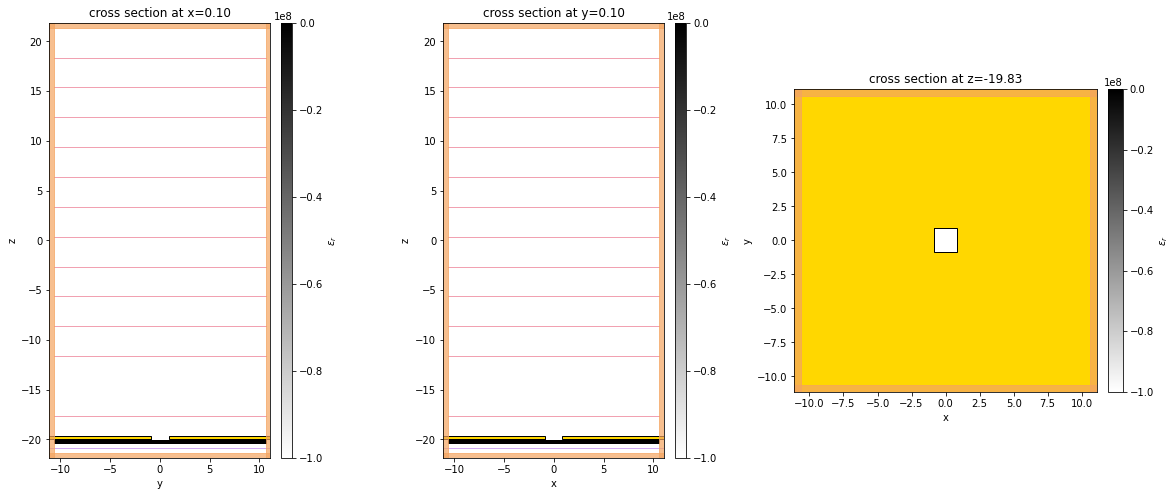

In [8]:
# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))

# # Time the visualization of the 2D plane
# td.viz.viz_eps_2D(sim, normal='x', position=0.1, ax=ax1);
# td.viz.viz_eps_2D(sim, normal='y', position=0.1, ax=ax2);
# td.viz.viz_eps_2D(sim, normal='z', position=-length_z/2 + space_below_sub + thickness_sub + H / 2, ax=ax3);

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8))
sim.plot_eps(x=0.1, ax=ax1);
sim.plot_eps(y=0.1, ax=ax2);
sim.plot_eps(z=-length_z/2 + space_below_sub + thickness_sub + H / 2, ax=ax3);

## Run Simulation

Now we can run the simulation over time and measure the results to plot


In [9]:
# Run simulation
import tidy3d.web as web
# sim_data = web.run(sim, task_name='near2far', path='data/sim_ap_2lamb_lenxy_p10lamb.hdf5')
sim_data = web.run(sim, task_name='near2far', path='data/simulation.hdf5')
# sim_data = web.load('3e650fd4-548e-4556-b38a-e473c3c53eb7', sim, path='data/simulation.hdf5')


[13:10:58] INFO     Uploaded task 'near2far' with task_id                       ]8;id=61430;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=40213;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#109\109]8;;\
                    '1a7e46fd-b5eb-44a0-95b6-e293c7bd6d00'.                                  

Output()

[13:10:59] status = queued                                                      ]8;id=116104;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=222305;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#201\201]8;;\

[13:11:19] status = preprocess                                                  ]8;id=990999;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=408954;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#201\201]8;;\

[13:11:53] status = running                                                     ]8;id=151649;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=255194;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#201\201]8;;\

[13:22:01] status = postprocess                                                 ]8;id=941762;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=398034;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#201\201]8;;\

[13:22:37] status = visualize                                                   ]8;id=793379;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=224623;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#201\201]8;;\

[13:22:49] status = success                                                     ]8;id=478901;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=51829;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#201\201]8;;\

[13:22:50] INFO     downloading file "monitor_data.hdf5" to                     ]8;id=366403;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=831862;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#480\480]8;;\
                    "data/simulation.hdf5"                                                   

Output()

[13:27:15] INFO     loading SimulationData from data/simulation.hdf5            ]8;id=639620;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=872151;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#301\301]8;;\

           WARNING  structure                                               ]8;id=767477;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=503043;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/components/simulation.py#243\243]8;;\
                                                                                             
                    geometry=Box(center=(0.0, 0.0, -20.2), type='Box',                       
                    size=(21.25, 21.25, 0.3333333333333333))                                 
                    medium=Medium(name=None, frequency_range=None,                           
                    type='Medium', permittivity=2.1315999999999997,                          
                    conductivity=0.0) name=None type='Structure'                             
                                                                                             
                    bounds extend exactly to simulation edges. This can                      
                    cause unexpected behavior. If intending to extend the                    
                    structure to infinity along one dimension, use td.inf                    
                    as a size variable instead to make this explicit.                        

           WARNING  structure                                               ]8;id=649865;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=236356;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/components/simulation.py#243\243]8;;\
                                                                                             
                    geometry=Box(center=(0.0, 0.0, -20.2), type='Box',                       
                    size=(21.25, 21.25, 0.3333333333333333))                                 
                    medium=Medium(name=None, frequency_range=None,                           
                    type='Medium', permittivity=2.1315999999999997,                          
                    conductivity=0.0) name=None type='Structure'                             
                                                                                             
                    bounds extend exactly to simulation edges. This can                      
                    cause unexpected behavior. If intending to extend the                    
                    structure to infinity along one dimension, use td.inf                    
                    as a size variable instead to make this explicit.                        

           WARNING  structure                                               ]8;id=519057;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=735306;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/components/simulation.py#243\243]8;;\
                                                                                             
                    geometry=Box(center=(0.0, 0.0, -20.2), type='Box',                       
                    size=(21.25, 21.25, 0.3333333333333333))                                 
                    medium=Medium(name=None, frequency_range=None,                           
                    type='Medium', permittivity=2.1315999999999997,                          
                    conductivity=0.0) name=None type='Structure'                             
                                                                                             
                    bounds extend exactly to simulation edges. This can                      
                    cause unexpected behavior. If intending to extend the                    
                    structure to infinity along one dimension, use td.inf                    
                    as a size variable instead to make this explicit.                        

           WARNING  structure                                               ]8;id=140581;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=433545;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d-docs/tidy3d/tidy3d/components/simulation.py#243\243]8;;\
                                                                                             
                    geometry=Box(center=(0.0, 0.0, -20.2), type='Box',                       
                    size=(21.25, 21.25, 0.3333333333333333))                                 
                    medium=Medium(name=None, frequency_range=None,                           
                    type='Medium', permittivity=2.1315999999999997,                          
                    conductivity=0.0) name=None type='Structure'                             
                                                                                             
                    bounds extend exactly to simulation edges. This can                      
                    cause unexpected behavior. If intending to extend the                    
                    structure to infinity along one dimension, use td.inf                    
                    as a size variable instead to make this explicit.                        

We now can inspect the field patterns on the area monitors using the Tidy3D built in field visualization methods.

<Figure size 1080x252 with 6 Axes>

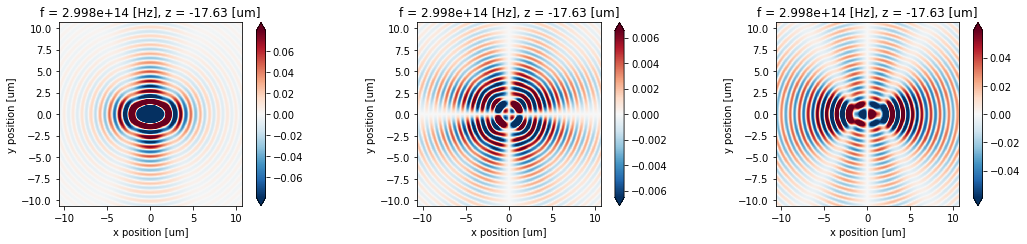

<Figure size 1080x252 with 6 Axes>

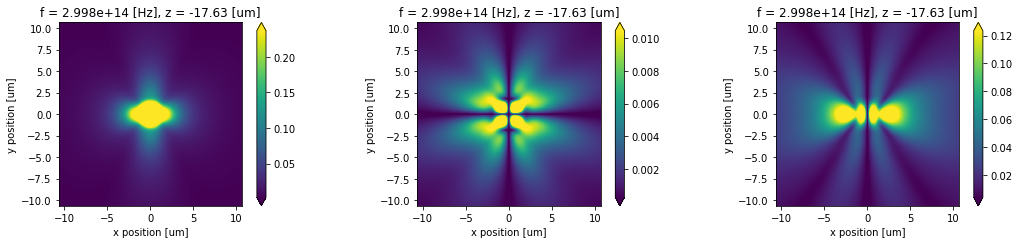

In [10]:
# fig, axes = plt.subplots(1, 3, figsize=(12, 4))
# for ax, val in zip(axes, ('re', 'abs', 'int')):
#     im = sim.viz_field_2D(monitor_near, eps_alpha=0.99, comp='x', val=val, cbar=True, ax=ax)
# # plt.savefig('out', dpi=400)
# plt.show()

near_field_data = sim_data['near_field']

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(15, 3.5))

sim_data.plot_field(field_monitor_name='near_field', field_name='Ex', z=near_plane_z, val='real', freq=f0, ax=ax1)
sim_data.plot_field(field_monitor_name='near_field', field_name='Ey', z=near_plane_z, val='real', freq=f0, ax=ax2)
sim_data.plot_field(field_monitor_name='near_field', field_name='Ez', z=near_plane_z, val='real', freq=f0, ax=ax3)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(15, 3.5))

sim_data.plot_field(field_monitor_name='near_field', field_name='Ex', z=near_plane_z, val='abs', freq=f0, ax=ax1)
sim_data.plot_field(field_monitor_name='near_field', field_name='Ey', z=near_plane_z, val='abs', freq=f0, ax=ax2)
sim_data.plot_field(field_monitor_name='near_field', field_name='Ez', z=near_plane_z, val='abs', freq=f0, ax=ax3)

plt.show()


<Figure size 1080x252 with 6 Axes>

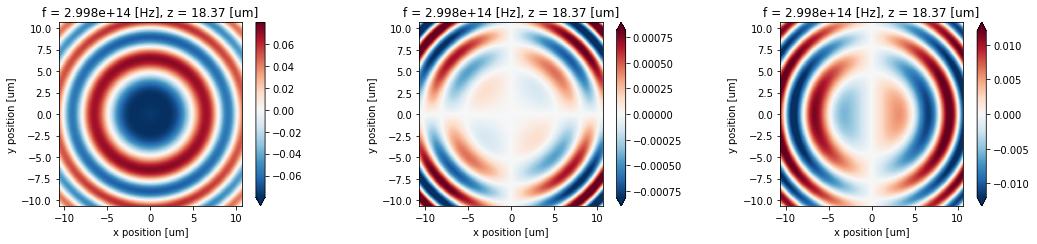

<Figure size 1080x252 with 6 Axes>

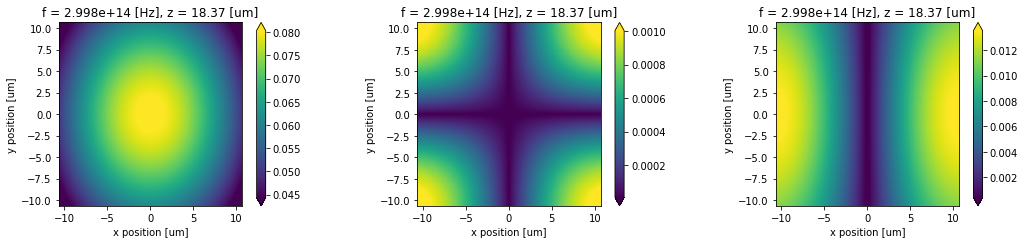

In [11]:
# fig, axes = plt.subplots(1, 3, figsize=(12, 4))
# for ax, val in zip(axes, ('re', 'abs', 'int')):
#     im = sim.viz_field_2D(monitor_far, eps_alpha=0.99, comp='x', val=val, cbar=True, ax=ax)
# # plt.savefig('out', dpi=400)
# plt.show()

far_field_data = sim_data['far_field']

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(15, 3.5))

sim_data.plot_field(field_monitor_name='far_field', field_name='Ex', z=far_plane_z, val='real', freq=f0, ax=ax1)
sim_data.plot_field(field_monitor_name='far_field', field_name='Ey', z=far_plane_z, val='real', freq=f0, ax=ax2)
sim_data.plot_field(field_monitor_name='far_field', field_name='Ez', z=far_plane_z, val='real', freq=f0, ax=ax3)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(15, 3.5))

sim_data.plot_field(field_monitor_name='far_field', field_name='Ex', z=far_plane_z, val='abs', freq=f0, ax=ax1)
sim_data.plot_field(field_monitor_name='far_field', field_name='Ey', z=far_plane_z, val='abs', freq=f0, ax=ax2)
sim_data.plot_field(field_monitor_name='far_field', field_name='Ez', z=far_plane_z, val='abs', freq=f0, ax=ax3)

plt.show()


In [12]:

from tidy3d.plugins import Near2Far

n2f = Near2Far(sim_data, mon_name='near_field', frequency=f0)


In [13]:
#import importlib
#importlib.reload(td.plugins.modules['Near2Far'])

# Select far field observation points so that they coincide with the FDTD grid centers
# to allow directly computing the relative error later on, without having to interpolate
step_n2f = 8
xs_n2f = sim.discretize(monitor_far).centers.x
ys_n2f = sim.discretize(monitor_far).centers.y
print(len(xs_n2f),len(xs_n2f))
xs_n2f = xs_n2f[::step_n2f]
ys_n2f = ys_n2f[::step_n2f]
print(len(xs_n2f),len(xs_n2f))

num_far_x = len(xs_n2f)
num_far_y = len(ys_n2f)

# points to project to
#num_far_x = 2
#num_far_y = 2
#xs_n2f = far_plane_xy * np.linspace(-0.5, 0.5, num_far_x)
#ys_n2f = far_plane_xy * np.linspace(-0.5, 0.5, num_far_y)

# initialize the far field values
Es = np.zeros((3, num_far_x, num_far_y), dtype=complex)
Hs = np.zeros((3, num_far_x, num_far_y), dtype=complex)        

from rich.progress import track

# loop through points in the output plane
for i in track(range(num_far_x), description='Performing Far-field transformation...'):

    x = xs_n2f[i]
    for j in range(num_far_y):
        y = ys_n2f[j]

        # compute and store the outputs from projection function at the focal plane
        E, H = n2f.fields_cartesian(x, y, far_plane_z-near_plane_z)
        Es[:, i, j] = np.squeeze(E)
        Hs[:, i, j] = np.squeeze(H)


Output()

533 533
67 67


<Figure size 936x648 with 18 Axes>

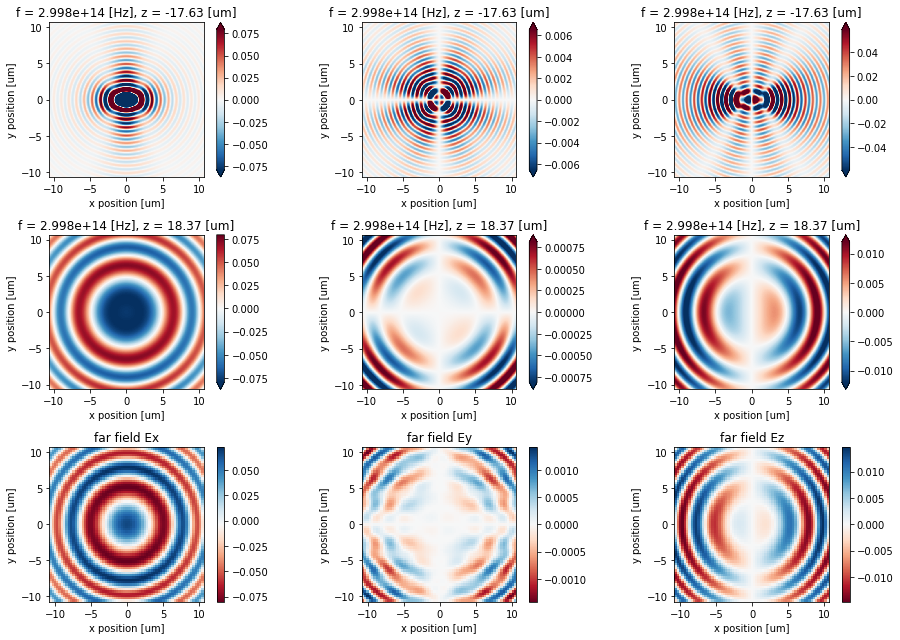

In [14]:
# plot everything
# fig, (axes_near, axes_near_ref, axes_far_ref, axes_near2far, axes_near2far_ref) =  plt.subplots(5, 3)
# fig.set_size_inches(13, 15)
fig, (axes_near, axes_far_ref, axes_near2far) =  plt.subplots(3, 3)
fig.set_size_inches(13, 9)
fig.tight_layout()

def pmesh(xs, ys, array, ax, cmap):
    im = ax.pcolormesh(xs, ys, array.T, cmap=cmap, shading='auto')
    return im

func = 'real'
def plotfunc(val):
    return np.real(val)

testpos = (1.8, 1.2)

# Near field in the original simulation
ax1, ax2, ax3 = axes_near
sim_data.plot_field(field_monitor_name='near_field', field_name='Ex', z=near_plane_z, val=func, freq=f0, ax=ax1)
sim_data.plot_field(field_monitor_name='near_field', field_name='Ey', z=near_plane_z, val=func, freq=f0, ax=ax2)
sim_data.plot_field(field_monitor_name='near_field', field_name='Ez', z=near_plane_z, val=func, freq=f0, ax=ax3)

# Far field at the monitor in the reference simulation
ax1, ax2, ax3 = axes_far_ref
sim_data.plot_field(field_monitor_name='far_field', field_name='Ex', z=far_plane_z, val=func, freq=f0, ax=ax1)
sim_data.plot_field(field_monitor_name='far_field', field_name='Ey', z=far_plane_z, val=func, freq=f0, ax=ax2)
sim_data.plot_field(field_monitor_name='far_field', field_name='Ez', z=far_plane_z, val=func, freq=f0, ax=ax3)

# Far field via near2far in the original simulation
for ax, direction, E in zip(axes_near2far, 'xyz', Es):
    im = pmesh(xs_n2f, ys_n2f, plotfunc(E), ax=ax, cmap='RdBu')
    ax.set_title(f'far field E{direction}')
    ax.set_aspect(1)
    ax.set_xlabel('x position [um]')
    ax.set_ylabel('y position [um]')
    plt.colorbar(im, ax=ax)

fig.tight_layout()
plt.show()

<Figure size 936x648 with 18 Axes>

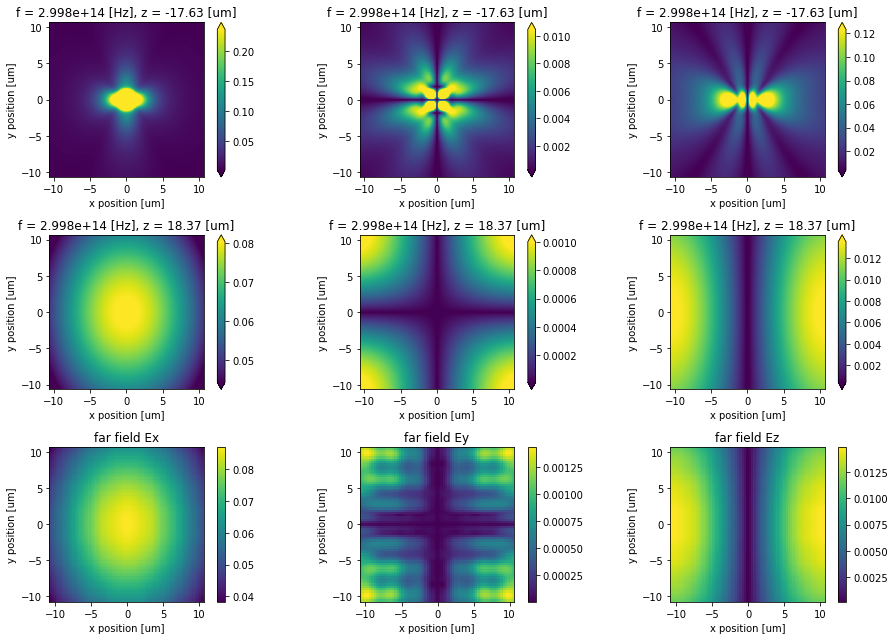

In [15]:
# plot everything
# fig, (axes_near, axes_near_ref, axes_far_ref, axes_near2far, axes_near2far_ref) =  plt.subplots(5, 3)
# fig.set_size_inches(13, 15)
fig, (axes_near, axes_far_ref, axes_near2far) =  plt.subplots(3, 3)
fig.set_size_inches(13, 9)
fig.tight_layout()

def pmesh(xs, ys, array, ax, cmap):
    im = ax.pcolormesh(xs, ys, array.T, cmap=cmap, shading='auto')
    return im

func = 'abs'
def plotfunc(val):
    return np.abs(val)

testpos = (1.8, 1.2)

# Near field in the original simulation
ax1, ax2, ax3 = axes_near
sim_data.plot_field(field_monitor_name='near_field', field_name='Ex', z=near_plane_z, val=func, freq=f0, ax=ax1)
sim_data.plot_field(field_monitor_name='near_field', field_name='Ey', z=near_plane_z, val=func, freq=f0, ax=ax2)
sim_data.plot_field(field_monitor_name='near_field', field_name='Ez', z=near_plane_z, val=func, freq=f0, ax=ax3)

# Far field at the monitor in the reference simulation
ax1, ax2, ax3 = axes_far_ref
sim_data.plot_field(field_monitor_name='far_field', field_name='Ex', z=far_plane_z, val=func, freq=f0, ax=ax1)
sim_data.plot_field(field_monitor_name='far_field', field_name='Ey', z=far_plane_z, val=func, freq=f0, ax=ax2)
sim_data.plot_field(field_monitor_name='far_field', field_name='Ez', z=far_plane_z, val=func, freq=f0, ax=ax3)

# Far field via near2far in the original simulation
for ax, direction, E in zip(axes_near2far, 'xyz', Es):
    im = pmesh(xs_n2f, ys_n2f, plotfunc(E), ax=ax, cmap='viridis')
    ax.set_title(f'far field E{direction}')
    ax.set_aspect(1)
    ax.set_xlabel('x position [um]')
    ax.set_ylabel('y position [um]')
    plt.colorbar(im, ax=ax)

fig.tight_layout()
plt.show()

Compute an error metric by extracting the field at cell centers for the far field monitor and comparing those values to those computed with the near2far functionality

0.0918062343413386 0.000805004282218648 0.013596743214640931 0.006515504264986152 7.157039294900903e-07 0.0001599724108119073


<Figure size 1080x864 with 24 Axes>

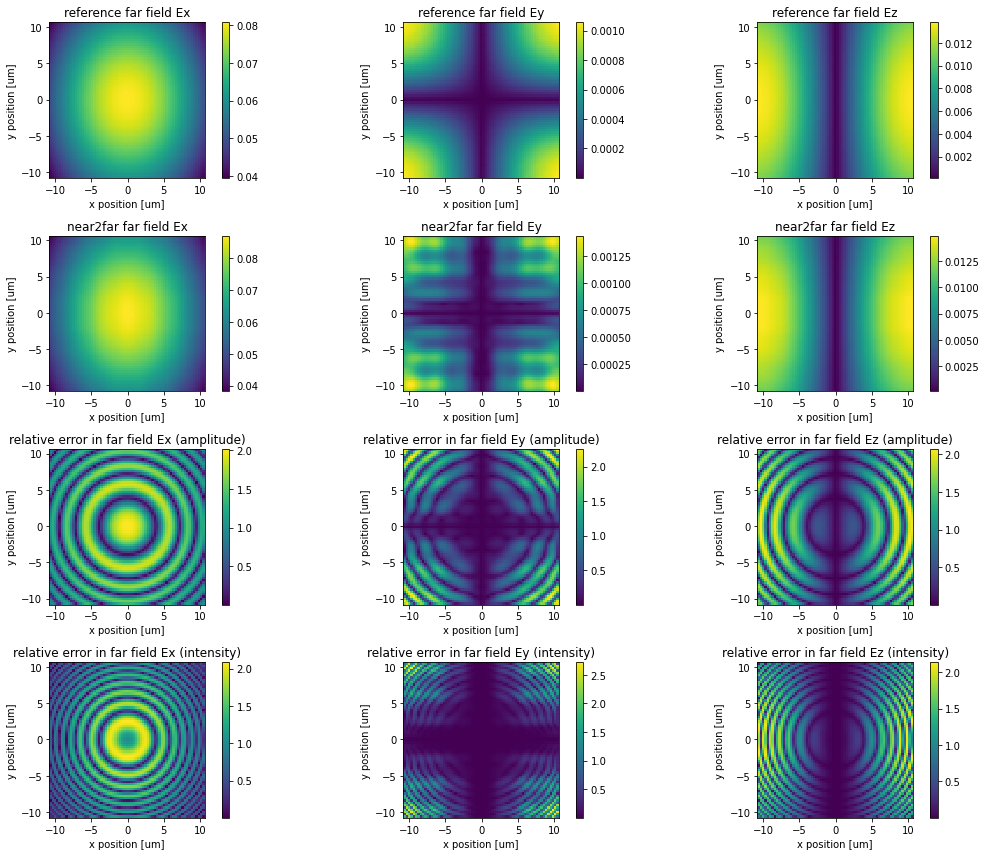

In [16]:

def get_err(mon_far_name, Es_test):
    
    far_field_refdata = sim_data.at_centers(mon_far_name)#.fillna(0)

    Ex_ref = far_field_refdata.Ex.sel(f=f0)
    Ey_ref = far_field_refdata.Ey.sel(f=f0)
    Ez_ref = far_field_refdata.Ez.sel(f=f0)

    x_ref = far_field_refdata.Ex.x
    y_ref = far_field_refdata.Ex.y

    x_ref = x_ref[::step_n2f]
    y_ref = y_ref[::step_n2f]

    Es_ref = []
    Es_ref.append(np.squeeze(Ex_ref[::step_n2f, ::step_n2f]))
    Es_ref.append(np.squeeze(Ey_ref[::step_n2f, ::step_n2f]))
    Es_ref.append(np.squeeze(Ez_ref[::step_n2f, ::step_n2f]))

    Es_err = []
    Es_in_err = []
    Es_rel_err = []
    Es_in_rel_err = []
    RMSE = []
    RMSE_in = []

    for i in range(3):
        Es_err.append(np.abs(Es_ref[i] - Es_test[i]))
        Es_rel_err.append(Es_err[i]/np.amax(np.abs(Es_ref[i])))
        Es_in_err.append(np.abs(np.asarray(Es_ref[i])**2 - np.asarray(Es_test[i])**2))
        Es_in_rel_err.append(Es_in_err[i]/np.amax(np.abs(np.asarray(Es_ref[i])**2)))
        RMSE.append(np.sqrt(np.mean(np.asarray(Es_err[i])**2)))
        RMSE_in.append(np.sqrt(np.mean(np.asarray(Es_in_err[i])**2)))

    return Es_ref, Es_err, Es_rel_err, Es_in_rel_err, RMSE, RMSE_in

Es_ref, Es_err, Es_rel_err, Es_in_rel_err, RMSE, RMSE_in = get_err("far_field", Es)

print(RMSE[0], RMSE[1], RMSE[2], RMSE_in[0], RMSE_in[1], RMSE_in[2])

fig, (ax_ref, ax_test, ax_err, ax_in_err) =  plt.subplots(4, 3)
fig.set_size_inches(15, 12)

for ax, direction, E in zip(ax_ref, 'xyz', Es_ref):
    im = pmesh(xs_n2f, ys_n2f, np.abs(E), ax=ax, cmap='viridis')
    ax.set_title(f'reference far field E{direction}')
    ax.set_aspect(1)
    ax.set_xlabel('x position [um]')
    ax.set_ylabel('y position [um]')
    plt.colorbar(im, ax=ax)

for ax, direction, E in zip(ax_test, 'xyz', Es):
    im = pmesh(xs_n2f, ys_n2f, np.abs(E), ax=ax, cmap='viridis')
    ax.set_title(f'near2far far field E{direction}')
    ax.set_aspect(1)
    ax.set_xlabel('x position [um]')
    ax.set_ylabel('y position [um]')
    plt.colorbar(im, ax=ax)

for ax, direction, E in zip(ax_err, 'xyz', Es_rel_err):
    im = pmesh(xs_n2f, ys_n2f, E, ax=ax, cmap='viridis')
    ax.set_title(f'relative error in far field E{direction} (amplitude)')
    ax.set_aspect(1)
    ax.set_xlabel('x position [um]')
    ax.set_ylabel('y position [um]')
    plt.colorbar(im, ax=ax)

for ax, direction, E in zip(ax_in_err, 'xyz', Es_in_rel_err):
    im = pmesh(xs_n2f, ys_n2f, E, ax=ax, cmap='viridis')
    ax.set_title(f'relative error in far field E{direction} (intensity)')
    ax.set_aspect(1)
    ax.set_xlabel('x position [um]')
    ax.set_ylabel('y position [um]')
    plt.colorbar(im, ax=ax)

fig.tight_layout()

Compute the far fields from near2far for far planes corresponding to all far monitors

In [17]:

Es_all = []
Hs_all = []

#mon_offsets = [3, 6, 9, 12, 15, 18, 21, 24]
mon_offsets_all = mon_offsets
mon_offsets_all.insert(0, 0.0)

dist = []
RMSE_Ex = []
RMSE_Ey = []
RMSE_Ez = []
RMSE_in_Ex = []
RMSE_in_Ey = []
RMSE_in_Ez = []

for m in range(len(mon_offsets_all)):

    mon_offset = mon_offsets_all[m]
    mon = monitors[m+1]

    # initialize the far field values
    Es = np.zeros((3, num_far_x, num_far_y), dtype=complex)
    Hs = np.zeros((3, num_far_x, num_far_y), dtype=complex)        

    # loop through points in the output plane
    for i in range(num_far_x):

        x = xs_n2f[i]
        for j in range(num_far_y):
            y = ys_n2f[j]

            # compute and store the outputs from projection function at the focal plane
            E, H = n2f.fields_cartesian(x, y, far_plane_z-near_plane_z-mon_offset)
            Es[:, i, j] = np.squeeze(E)
            Hs[:, i, j] = np.squeeze(H)
    
    # Es_all.append(Es)
    # Hs_all.append(Hs)
    
    Es_ref, Es_err, Es_rel_err, Es_in_rel_err, RMSE, RMSE_in = get_err(mon.name, Es)
    
    dist.append(z0 - mon_offset * wavelength)
    RMSE_Ex.append(RMSE[0])
    RMSE_Ey.append(RMSE[1])
    RMSE_Ez.append(RMSE[2])

    RMSE_in_Ex.append(RMSE_in[0])
    RMSE_in_Ey.append(RMSE_in[1])
    RMSE_in_Ez.append(RMSE_in[2])

    print(dist[m], RMSE_Ex[m], RMSE_Ey[m], RMSE_Ez[m], RMSE_in_Ex[m], RMSE_in_Ey[m], RMSE_in_Ez[m])
    

36.0 0.0918062343413386 0.000805004282218648 0.013596743214640931 0.006515504264986152 7.157039294900903e-07 0.0001599724108119073
33 0.09585897403053892 0.0009323485943488566 0.015019563862563435 0.007271208436105209 9.212422017238619e-07 0.00019580344143187693
30 0.10042604449515316 0.001087512580197805 0.01671297380768363 0.008157899573861399 1.1958943362589685e-06 0.00023990659422846485
27 0.10548473699754764 0.0012972606862846688 0.018651845569845206 0.009196450517118534 1.6649952759198706e-06 0.00029191673657628426
24 0.10961821911972755 0.0015102143416059596 0.020488974536065237 0.010453726305946277 2.178722603693622e-06 0.0003531113785462766
21 0.11411588121443077 0.0017468269968238224 0.022435653277933867 0.012021277019487875 2.8298035644282863e-06 0.00042316475874901725
18 0.11776189063784155 0.001982217026606279 0.024124270621144625 0.01405103875930268 3.602264670978505e-06 0.0005053925411072762
15 0.12085187087716988 0.0022363748465237007 0.025514414041416744 0.016801511512

Plot the RMSE as a function of the distance of the far field observation plane from the near field plane

<Figure size 504x216 with 1 Axes>

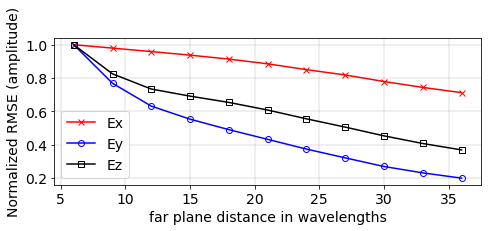

<Figure size 504x216 with 1 Axes>

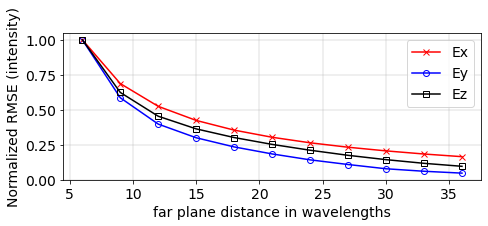

In [20]:
#dist = [30, 27, 24, 21, 18, 15, 12, 9, 6]
#RMSE_Ex = [0.2041824534781689, 0.20614317276034594, 0.20883100173418276, 0.21261367793706853, 0.21584980674551849, 0.21825489556400407, 0.22035219613283968, 0.22370011843050233, 0.22819269565294134]
#RMSE_Ey = [0.0018142729419134839, 0.0019153760283263448, 0.0021391069048989153, 0.002521815600080034, 0.0030429708191590165, 0.00362220601454377, 0.0041775351559689925, 0.004804238098756023, 0.0056189981456711835]
#RMSE_Ez = [0.020614123317904152, 0.02195887363721307, 0.023793389510958652, 0.026303099139017943, 0.028086186324097286, 0.02922568587742748, 0.03138103657534356, 0.03486428830008631, 0.03902776455707314]

from matplotlib import rc

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

#rc("text", usetex = False)
rc('font', **font)

fig, ax = plt.subplots(figsize=(7, 3))
ax.plot(np.asarray(dist)/wavelength, RMSE_Ex/np.max(np.abs(RMSE_Ex)), 'r-x', label='Ex', mfc='none')
ax.plot(np.asarray(dist)/wavelength, RMSE_Ey/np.max(np.abs(RMSE_Ey)), 'b-o', label='Ey', mfc='none')
ax.plot(np.asarray(dist)/wavelength, RMSE_Ez/np.max(np.abs(RMSE_Ez)), 'k-s', label='Ez', mfc='none')
ax.grid(visible = True, which = 'both', axis = 'both', linewidth = 0.4)
ax.set(xlabel = 'far plane distance in wavelengths',
       ylabel = 'Normalized RMSE (amplitude)',
       xscale = 'linear',
       yscale = 'linear')
ax.legend(loc='best', prop={'size': 14})
fig.tight_layout()

fig, ax = plt.subplots(figsize=(7, 3))
ax.plot(np.asarray(dist)/wavelength, RMSE_in_Ex/np.max(np.abs(RMSE_in_Ex)), 'r-x', label='Ex', mfc='none')
ax.plot(np.asarray(dist)/wavelength, RMSE_in_Ey/np.max(np.abs(RMSE_in_Ey)), 'b-o', label='Ey', mfc='none')
ax.plot(np.asarray(dist)/wavelength, RMSE_in_Ez/np.max(np.abs(RMSE_in_Ez)), 'k-s', label='Ez', mfc='none')
ax.grid(visible = True, which = 'both', axis = 'both', linewidth = 0.4)
ax.set(xlabel = 'far plane distance in wavelengths',
       ylabel = 'Normalized RMSE (intensity)',
       xscale = 'linear',
       yscale = 'linear')
ax.legend(loc='best', prop={'size': 14})
fig.tight_layout()


